In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import env

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

## Acquire Stage

In [42]:
# connection function for accessing mysql 
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

query = """
select * 
from properties_2017
join predictions_2017 using(parcelid)
where transactiondate between "2017-05-01" and "2017-06-30";
"""

df = pd.read_sql(query, get_connection('zillow'))
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,11393337,2463969,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,43439.0,2016.0,22755.0,756.94,Y,14.0,6.037235e+13,117,0.086137,2017-06-08
1,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
2,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30
3,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,None,NaN,6.059064e+13,2028,0.021085,2017-06-01
4,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,None,NaN,6.037703e+13,3273,-0.325393,2017-06-01


## Let's do a little prep on this Zillow data

In [43]:
# Some prep
df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "square_feet", "taxamount": "taxes", "taxvaluedollarcnt": "tax_value"})

In [44]:
features = [
    "parcelid",
    "bedrooms",
    "bathrooms",
    "square_feet",
    "tax_value"
]

df = df[features]
df = df.set_index("parcelid")
df.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11393337,3.0,3.0,1534.0,43439.0
11289917,3.0,2.0,1458.0,136104.0
11705026,2.0,1.0,1421.0,35606.0
14269464,4.0,3.0,2541.0,880456.0
11389003,3.0,2.0,1650.0,614000.0


In [45]:
# how many records do we have?
df.shape

(21943, 4)

In [46]:
# how many nulls do I have?
df.isna().sum()

bedrooms        6
bathrooms       6
square_feet    61
tax_value       6
dtype: int64

In [47]:
# Let's drop the nulls
df = df.dropna()
df.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11393337,3.0,3.0,1534.0,43439.0
11289917,3.0,2.0,1458.0,136104.0
11705026,2.0,1.0,1421.0,35606.0
14269464,4.0,3.0,2541.0,880456.0
11389003,3.0,2.0,1650.0,614000.0


In [48]:
def split_data(df, stratify_by=""):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [49]:
train, validate, test = split_data(df, stratify_by="tax_value")

In [50]:
train.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11834559,2.0,1.0,652.0,26038.0
14090662,3.0,1.5,1120.0,189649.0
11322593,3.0,2.0,2222.0,376790.0
10983576,4.0,3.0,1661.0,264420.0
11048674,3.0,2.0,1252.0,52552.0


<AxesSubplot:>

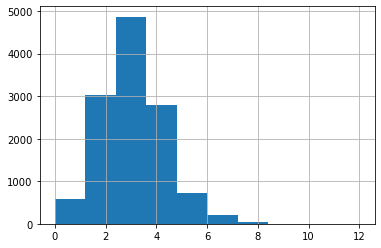

In [51]:
train.bedrooms.hist()

<AxesSubplot:>

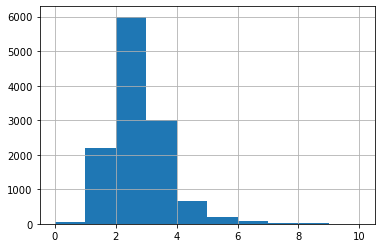

In [52]:
train.bathrooms.hist()

<AxesSubplot:>

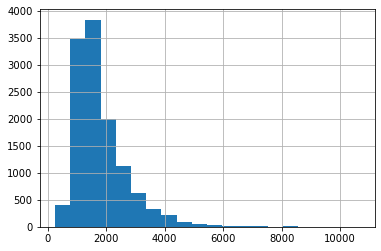

In [57]:
train.square_feet.hist(bins=20)

In [83]:
train.tax_value.max()

23858374

## Ok.. Scaling... Now What?
- Do the 3 Step sklearn API
    1. Make the thing (Make a scaler object
    2. Fit the thing (on the train data)
    3. Use the thing


In [70]:
scaler = sklearn.preprocessing.MinMaxScaler()

scaler.fit(train)

MinMaxScaler()

In [72]:
train_scaled = scaler.transform(train)
validate_scaled = scaler.transform(validate)
test_scaled = scaler.transform(validate)

In [77]:
# turn the numpy arrays into dataframes
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
test_scaled = pd.DataFrame(test_scaled, columns=train.columns)

In [78]:
train_scaled.head()

,bedrooms,bathrooms,square_feet,tax_value
0,0.166667,0.10,0.039370,0.000651
1,0.250000,0.15,0.084310,0.007512
2,0.250000,0.20,0.190129,0.015359
3,0.333333,0.30,0.136259,0.010647
4,0.250000,0.20,0.096985,0.001763


<AxesSubplot:>

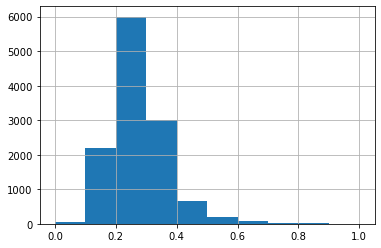

In [88]:
train_scaled.bathrooms.hist()

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

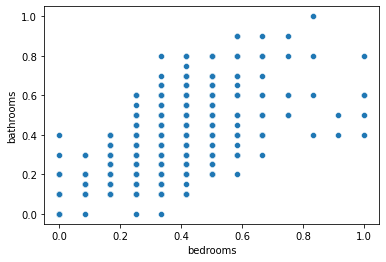

In [89]:
sns.scatterplot(x="bedrooms", y="bathrooms", data=train_scaled)